In [1]:
import os
import sys
import numpy as np
import pandas as pd

IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR)

from imatools.common import vtktools as vtku
from imatools.common import ioutils as iou

def calc_cog(pts, el):
    return [np.mean(pts[ee], 0) for ee in el]


def norm2(a): return np.linalg.norm(a)
def norm_vec(a): return a/norm2(a)


def remove_from_dirlist(dir_list, name_to_rm):
    if name_to_rm in dir_list:
        dir_list.remove(name_to_rm)

    return dir_list

def perc_above(arr, th) : 
    return np.sum(arr>th) / len(arr)

def perc_below(arr, th) : 
    return np.sum(arr<th) / len(arr)


# Locations of hard drive based on platform
dirdic = {'macOS': '/Volumes/sandisk',
          'Linux': '/media/jsl19/sandisk',
          'Windows': 'D:/'}

tex_dic = {'macOS': '/Users/jsolislemus/Documents/TEX',
           'Linux': '/home/jsl19/Documents/tex'}

base_dir = iou.fullfile(dirdic[iou.chooseplatform()], '01_atrialfibres/06_Reproducibility/05_UserProjects')
comp_dir = iou.fullfile(base_dir, '011_comparisons')

ld = remove_from_dirlist(os.listdir(iou.fullfile(comp_dir,'C0')), 'COMPARISONS')
ld = remove_from_dirlist(ld, 'MAPPING')

CX = ['C' + str(n) for n in np.linspace(0,49,num=50, dtype=int)]

print(ld)

['M1', 'M2']


# Preliminaries: 
+ Get comparison paths and create the `processing` and `mode` lists
+ Create local_cv files using the `gradlat` files 

In [2]:
df_comp = pd.read_csv(iou.fullfile(comp_dir, 'comparisons_path.csv'))
mode = df_comp['mode']
mode = mode[np.linspace(0,98,num=50, dtype=int)]

processing_raw = df_comp['processing'].tolist()
processing_raw = [processing_raw[ix] + processing_raw[ix+1] for ix in range(50)]

a='automatic'
m='manual'

processing = [p.replace(a+a, a) for p in processing_raw]
processing = [p.replace(m+m, m) for p in processing]
processing = [p.replace(a+m, 'mixed') for p in processing]
processing = [p.replace(m+a, 'mixed') for p in processing]

files_and_mapping = {
    'lat': ('LAT_RSPV_X.dat', 'fibre_X_pts.csv'),
    'cv': ('local_cv_X.dat', 'fibre_X_pts.csv'),
    'gradlat': ('lat_X.gradmag.dat', 'fibre_X_pts.csv'),
    'ps': ('PSNodeSmooth.dat', 'input_pts.csv'),
    'f_endo': ('fibre_X_endo.lon', 'fibre_X_endo_elem.csv'),
    'f_epi': ('fibre_X_epi.lon', 'fibre_X_epi_elem.csv')
}



Create comparison list

In [3]:
if iou.chooseplatform() == 'Linux':
    comparison_list = [c.replace('/Volumes', '/media/jsl19')
                       for c in df_comp['comparison_path'].tolist()]
else:
    comparison_list = df_comp['comparison_path'].tolist()
cx = 0  # go in even numbers!

comp_a = comparison_list[cx]
comp_b = comparison_list[cx+1]


## Create local cv
Create `local_cv_X.dat` files with the reciprocal of each `gradlat_X.dat`

In [4]:
dx = 'gradlat'
mmxx = ['1', 'l'] 

mx = mmxx[0]

for c in comparison_list : 
    for mx in mmxx : 
        fname = files_and_mapping[dx][0].replace('X', mx)
        gradlat = np.loadtxt(iou.fullfile(c, fname))
        qrts = iou.get_boxplot_values(gradlat)
        gradlat[gradlat < qrts['low_whisker']] = np.nan
        lcv = 1/gradlat
        
        np.savetxt(iou.fullfile(c, 'local_cv_' + mx + '.dat'), lcv)

iou.cout('Finished')

[INFO] Finished


{'min': 239.7943523634131, 'low_whisker': 239.7943523634131, 'low_quartile': 583.7234551758759, 'median': 678.8290199484227, 'high_quartile': 835.7360745476578, 'high_whisker': 1213.7550036053308, 'max': 2401.9811540558653}


<AxesSubplot:>

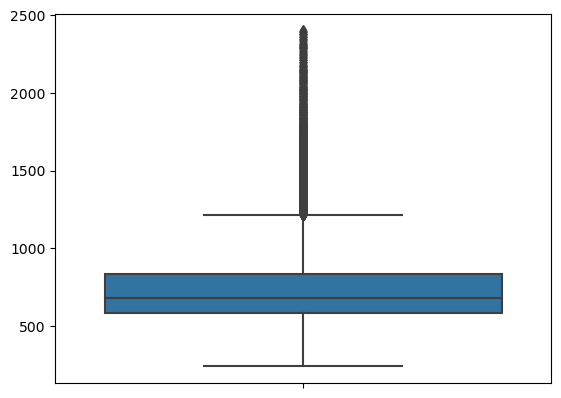

In [5]:
import seaborn as sns

dx = 'cv'
mx = 'l'

cx = 0
comp_a = iou.fullfile(comparison_list[cx], files_and_mapping[dx][0].replace('X', mx))
comp_b = iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))

f_a = np.loadtxt(comp_a)
f_b = np.loadtxt(comp_b)

print(iou.get_boxplot_values(f_a))
sns.boxplot(y=f_a)


In [21]:
import scipy.stats as sstat

def cname(dx, mx) : 
    return dx + '_' + mx + '.csv' 

dx = 'lat'
mx = 'l'

cx = 0
comparison_file = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', cname(dx, mx))

df = pd.read_csv(comparison_file, skipinitialspace=True)



comp_a = iou.fullfile(comparison_list[cx], files_and_mapping[dx][0].replace('X', mx))
comp_b = iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))

f_a = np.loadtxt(comp_a)
f_b = np.loadtxt(comp_b)

TAT = lambda x : np.nanmax(x) - np.nanmin(x)
print('A: {}, B: {}, diff : {}'.format(TAT(f_a), TAT(f_b), TAT(f_a)-TAT(f_b)))

# np.corrcoef(df['lat_0'], df['lat_1'])
sstat.pearsonr(df['lat_0'], df['lat_1'])


A: 143.6578, B: 137.4167, diff : 6.241100000000017


PearsonRResult(statistic=0.9652968420564989, pvalue=0.0)

<AxesSubplot:>

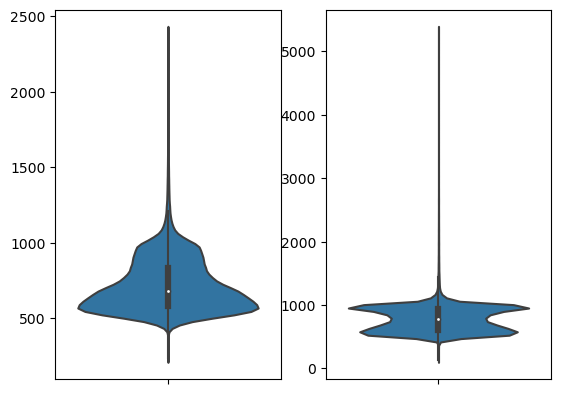

In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns

f_a

fig, ax = plt.subplots(1,2)
# sns.histplot(ax=ax[0], x=f_a, bins=50, stat='percent')
# sns.histplot(ax=ax[1], x=f_b, bins=50, stat='percent')

sns.violinplot(ax=ax[0], y=f_a)
sns.violinplot(ax=ax[1], y=f_b)

0.9968230853383758

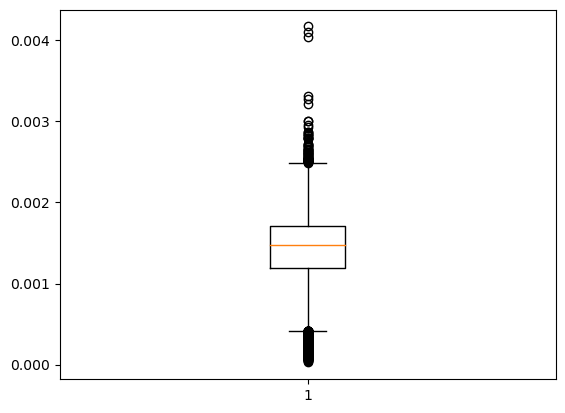

In [38]:

def get_boxplot_values(data) : 
    B = plt.boxplot(data)
    whis = [item.get_ydata()[1] for item in B['whiskers']]
    midic = {
        'min' : np.min(data), 
        'low_whisker' : whis[0],
        'low_box' : np.percentile(data, 25), 
        'median' : np.median(data), 
        'high_box' : np.percentile(data, 75), 
        'high_whisker' : whis[1], 
        'max' : np.max(data)
    }
    return midic
    

d = get_boxplot_values(1/f_a)
perc_above(1/f_a, d['low_whisker'])